# Continuous Control

---

This notebook uses the [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/) environment to train a DDPG model for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._


### 1. Start the Environment

If the code cell below returns an error, please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and all the required libraries.

In [1]:
from collections import deque

from unityagents import UnityEnvironment

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:
env = UnityEnvironment(file_name='env/Reacher20')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. State and Action Spaces

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents.

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# number of actions
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the policy

In [4]:
def step_env(actions):
    
    env_info = env.step(actions)[brain_name]    # sends the action of each agent for the environment
    next_states = env_info.vector_observations  # get the next state for each agent
    rewards =  env_info.rewards                 # get the reward for each agent
    dones = env_info.local_done                 # check if any episode has finished
    
    return next_states, rewards, dones, env_info

def ddpg(agent, n_episodes=2000, max_t=1000):
    
    scores = []                        # list with the scores from each episode
    scores_window = deque(maxlen=100)  # last 10 scores
    scores_window_mean =  []           # the mean of the last 10 episodes
    scores_window_std  =  []           # std of the last 10 episodes
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        agent.reset()
        states = env_info.vector_observations             # get the current state for each agent
        score = 0.0                                       # initialize the score for each agent
        for t in range(max_t):
            actions = agent.act(states)                     # selects an action
            next_states, rewards, dones,_ = step_env(actions) # sends the action and obtain next_states, rewards, 
                                                            # dones for each agent
            
            agent.step(states, actions, rewards, next_states, dones) # execute the action
            
            states = next_states      # update the current state
            score += np.mean(rewards) # update the score
            
            if np.any(dones):
                break
            
        scores.append(score)                           # save most recent score
        scores_window.append(score)                    
        w_score_mean = np.mean(scores_window)
        scores_window_mean.append(w_score_mean)
        scores_window_std.append(np.std(scores_window))
        
        print('\rEpisode {}\tAverage Score: {:.2f} \tScore: {:.2f}'.format(i_episode, w_score_mean, score), end="")
        
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tScore: {:.2f}'.format(i_episode, w_score_mean, score))     
        
        if w_score_mean >= 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, w_score_mean))
            
            filename = "checkpoints/{}_checkpoint_{}.pth"
            torch.save(agent.actor_local.state_dict(),  filename.format(type(agent).__name__, "actor"))
            torch.save(agent.critic_local.state_dict(), filename.format(type(agent).__name__, "critic"))
            break
            
    return (scores, scores_window_mean, scores_window_std)

DDPG Agent

In [5]:
from ddpg.agent import DDPGAgent
agent = DDPGAgent(state_size, action_size, num_agents, seed=42, update_frequency=20, n_learn=10)

Checking the architecture of the Actor and Critic network

In [6]:
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


Training an DDPG agent 

In [ ]:
scores, scores_window_mean, scores_window_std = ddpg(agent)

Episode 10	Average Score: 0.20 	Score: 0.16
Episode 20	Average Score: 0.35 	Score: 0.85
Episode 30	Average Score: 0.54 	Score: 1.17
Episode 40	Average Score: 0.79 	Score: 1.31
Episode 50	Average Score: 0.91 	Score: 1.47
Episode 60	Average Score: 1.13 	Score: 2.92
Episode 70	Average Score: 1.38 	Score: 3.57
Episode 80	Average Score: 1.69 	Score: 4.14
Episode 90	Average Score: 1.95 	Score: 4.74
Episode 100	Average Score: 2.20 	Score: 4.57
Episode 110	Average Score: 2.71 	Score: 5.87
Episode 120	Average Score: 3.19 	Score: 5.99
Episode 130	Average Score: 3.67 	Score: 5.47
Episode 140	Average Score: 4.11 	Score: 5.59
Episode 150	Average Score: 4.63 	Score: 6.78
Episode 160	Average Score: 5.10 	Score: 7.54
Episode 170	Average Score: 5.51 	Score: 5.66
Episode 180	Average Score: 5.86 	Score: 7.97
Episode 190	Average Score: 6.26 	Score: 8.94
Episode 200	Average Score: 6.67 	Score: 8.92
Episode 210	Average Score: 7.08 	Score: 9.191
Episode 220	Average Score: 7.42 	Score: 8.181
Episode 230	Avera

## 4. Visualizing the scores

In [25]:
def plot_scores(scores, rolling_mean, rolling_std, title, filename=''):
    
    """Plot the scores with the moving average"""
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    
    ax.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', alpha=0.9, label="Score threshold baseline")
    
    plt.plot(np.arange(len(scores)), scores);
    plt.plot(np.arange(len(rolling_mean)), rolling_mean,label='Moving average');
    plt.fill_between(np.arange(len(rolling_mean)), rolling_mean + rolling_std, rolling_mean - rolling_std, 
                     facecolor='green', alpha=0.4, label="Std of the moving average");
    plt.ylabel("Score"); plt.xlabel("Episode #"); plt.title(title);
    ax.legend(loc='upper left')
    ax.set_xlim(0, len(scores) + 1)
    
    if filename != '':
        fig.savefig(filename, format='pdf')

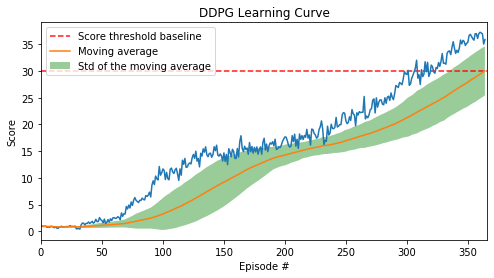

In [27]:
plot_scores(scores, np.array(scores_window_mean), np.array(scores_window_std), 
            title='DDPG Learning Curve', filename='report/figures/{}_score.pdf'.format(type(agent).__name__));

## 5. Watch a smart agent

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoints/{}_checkpoint_actor.pth'.format(type(agent).__name__)))
agent.critic_local.load_state_dict(torch.load('checkpoint/{}_checkpoint_critic.pth'.format(type(agent).__name__)))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state for each agent
scores = np.zeros(num_agents)                          # initialize the score for each agent

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get the next state for each agent
    rewards = env_info.rewards                         # get the reward for each agent
    dones = env_info.local_done                        # see if episode has finished
    scores += env_info.rewards                         # update the score for each agent
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Close the environment

In [ ]:
env.close()